In [10]:
from __future__ import print_function, division

In [11]:
import requests
import time
from bs4 import BeautifulSoup
import random
# import urllib2
# from urllib2 import URLError
import time
import re

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import scipy.stats

from IPython.display import Image
%matplotlib inline

In [13]:
# Top grossing 100 movies from 2016.
url = "http://www.boxofficemojo.com/yearly/chart/?yr=2016&view=releasedate&view2=domestic&sort=gross&order=DESC&&p=.htm"
response = requests.get(url)
response.status_code
page = response.text
soup = BeautifulSoup(page, "lxml")
tables = soup.find_all("table")
rows=[row for row in tables[3].find_all('tr')]

In [14]:
#get the table in the webpage including name of movie, total_gross, open and close information, etc
movies={}
for row in rows[6:106]:
    items=row.find_all('td')
    title=items[1].find('a')['href'][14:-4]
    movies[title] = [i.text for i in items[1:]]
list(movies.items());
box_office = list(movies.items())
df = pd.DataFrame.from_items(box_office).T
df = df.reset_index()
df = df[[0,1,2,3,4,5,6,7]]
df = df.rename(columns={0:"Movie",1:"Studio",2:"Total_Gross",3:"Theaters",4:"Opening",5:"Theaters2",6:"Open",7:"Close"})

In [15]:
#generate the links of each movies based on their names to get more information
linklist = []
for row in rows[6:106]:
    items = row.find_all("td")
    link = items[1].find("a")['href']
    linklist.append(("http://www.boxofficemojo.com/"+link))  
linklist;

In [16]:
# In each link, extract the information including Runtime, MPAA, Rating, Production Budget,Director which are not in the 
#orignal tables.
def getrunrating(linklist):
    runtime_list =[]
    rating_list =[]
    budget_list = []
    director_list = []
    for link2 in linklist:
        response2 = requests.get(link2)
        page2 = response2.text
        soup2 = BeautifulSoup(page2, "lxml")
        tables2 = soup2.find_all("table")
        rows=[row for row in tables[3].find_all('tr')]

        dtg_string2 = soup2.find(text=re.compile('Runtime'))
        runtime_list.append(dtg_string2.findNext().text)

        dtg_string3 = soup2.find(text=re.compile('MPAA Rating'))
        rating_list.append(dtg_string3.findNext().text)
        
        dtg_string4 = soup2.find(text=re.compile('Production Budget'))
        budget_list.append(dtg_string4.findNext().text)
        
        try:
            dtg_string5 = soup2.find(text=re.compile('Director'))
            director_list.append(dtg_string5.findNext().text)
        except:
            director_list.append("N/A")
    return runtime_list,rating_list,budget_list,director_list

In [17]:
#Call the function above
runtime_list,rating_list,budget_list,director_list = getrunrating(linklist)

In [18]:
#Incorporate the information above into the orginal table
df["Runtime"] = runtime_list
df["Rating"] = rating_list
df["Budget"] = budget_list
df["Director"] = director_list

In [19]:
#data clean
run_time =lambda x:pd.datetime.strptime(x, "%H hrs. %M min.").hour*60+pd.datetime.strptime(x, "%H hrs. %M min.").minute*1
df["Runtime"] = df["Runtime"].apply(run_time)
df["Budget"] = df["Budget"].apply(lambda x:1000000 if x == "N/A" else float(x[1:-8])*1000000)
df["Total_Gross"] = df["Total_Gross"].apply(lambda x:int(x.replace(",","")[1:]))
df = df.drop(['Opening', "Theaters","Theaters2"],axis=1)
df["Open"] = df["Open"].apply(lambda x:x+"/2016")
df["Open"] = df["Open"].apply(lambda x:dt.datetime.strptime(x,"%m/%d/%Y").date())


In [20]:
df.head()

,Movie,Studio,Total_Gross,Open,Close,Runtime,Rating,Budget,Director
0,Rogue One: A Star Wars Story,BV,532177324,2016-12-16,5/4,133,PG-13,200000000.0,Gareth Edwards
1,Finding Dory,BV,486295561,2016-06-17,12/8,103,PG,1000000.0,Angus MacLane (co-director)Andrew Stanton
2,Captain America: Civil War,BV,408084349,2016-05-06,9/22,147,PG-13,250000000.0,Anthony RussoJoe Russo
3,The Secret Life of Pets,Uni.,368384330,2016-07-08,12/29,90,PG,75000000.0,Chris Renaud
4,The Jungle Book (2016),BV,364001123,2016-04-15,9/29,105,PG,175000000.0,Jon Favreau


Challenge 1: Plot domestic total gross over time.

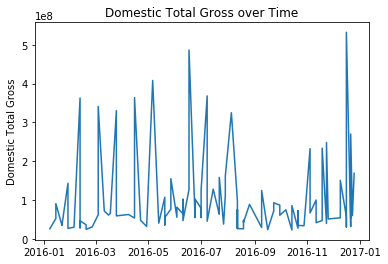

In [21]:
x = df.sort_values("Open")["Open"].values
y = df.sort_values("Open")["Total_Gross"].values
plt.plot(x,y)
plt.title("Domestic Total Gross over Time")
plt.ylabel("Domestic Total Gross")

Challenge 2: Plot runtime vs. domestic total gross.

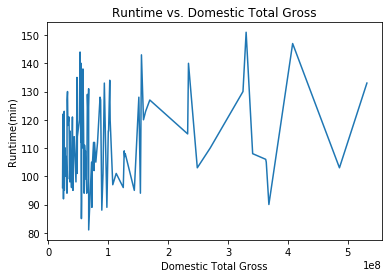

In [22]:
y = df["Runtime"].values
x = df["Total_Gross"].values
plt.plot(x,y)
plt.title("Runtime vs. Domestic Total Gross")
plt.ylabel("Runtime(min)")
plt.xlabel("Domestic Total Gross")

Challenge 3：Group your data by Rating and find the average runtime and domestic total gross at each level of Rating.

In [23]:
df.groupby("Rating")["Runtime","Total_Gross"].mean()

,Runtime,Total_Gross
Rating,,
PG,103.294118,1.828467e+08
PG-13,114.870370,9.914273e+07
R,109.862069,6.618171e+07


Challenge 4: Make one figure with (N=the number of MPAA ratings there are) subplots, and in each plot the release date vs the domestic total gross.

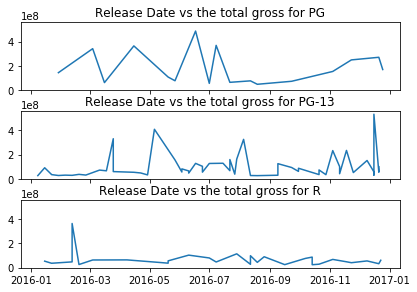

In [24]:
fig, ax = plt.subplots(3, 1, sharex='all', sharey='all')
fig.tight_layout()
count = 0
title_list = ["PG","PG-13","R"]
for name,group in df.groupby("Rating"):
    x = group.sort_values("Open")["Open"].values
    y = group.sort_values("Open")["Total_Gross"].values
    ax[count].plot(x,y)
    title_name = "Release Date vs the total gross for %s"%(title_list[count])
    ax[count].set_title(title_name)
    count +=1

Challenge 5:What director in your dataset has the highest gross per movie?

In [25]:
df.groupby("Director")["Total_Gross"].mean().sort_values(ascending = False).index[0]

'Gareth Edwards'

Challenge 6: 
Bin your dataset into months and make a bar graph of the mean domestic total gross by month. 
Error bars will represent the standard error of the mean.
Title of graph should include: Mean Domestic Total Gross by Month in 2013
Topic for consideration: what is the correct formula for the standard error of the mean? 
Examine the error bars and see if they are "reasonable."

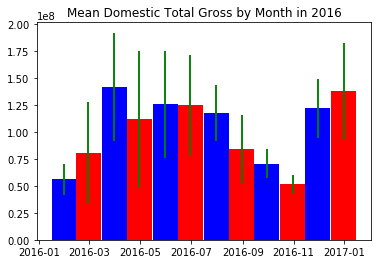

In [26]:
df2 = df.set_index("Open")
df2.index = pd.to_datetime(df2.index)
df2 = df2.groupby(pd.TimeGrouper(freq = "m"))["Total_Gross"].agg([scipy.stats.sem,"mean"])
for index,row in df2.iteritems():
    plt.bar(df2.index,df2["mean"],width = 30,color=["b","r"])
    plt.errorbar(df2.index,df2["mean"],df2["sem"],color = "g",fmt = "none")
plt.title("Mean Domestic Total Gross by Month in 2016")